In [1]:
import numpy as np
import pandas as pd
import optuna
import gc

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import time

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
# LGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [6]:
train = pd.read_pickle("../input/pytorch-lightning/train.pkl")
test = pd.read_pickle("../input/pytorch-lightning/test.pkl")

In [7]:
sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")

In [8]:
# meta modelのハイパラ調整
train_folds = train[train['fold']!=0]
valid_folds = train[train['fold']==0]
X_train = train_folds[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
y_train = train_folds['target']
X_valid = valid_folds[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
y_valid = valid_folds['target']
X_test = test[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]

def objective(trial):
    # reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-20, 1e1)
    reg_alpha = 0
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-13*1e-1, 1e-13*1e1)
    num_leaves = trial.suggest_int('num_leaves', 817-100,817+100)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6-0.1, 0.6+0.1)
    subsample = trial.suggest_uniform('subsample', 0.77-0.1, 0.77+0.1)
    subsample_freq = trial.suggest_int('subsample_freq', 211-100, 211+100)
    max_depth = trial.suggest_int('max_depth', 2,1000)
    max_bins = trial.suggest_int('max_bins', 2,1000)
    min_child_samples = trial.suggest_int('min_child_samples', 992-100, 992+100)
    lr = trial.suggest_loguniform('lr', 1e-6*1e-1, 1e-6*1e1)
    try:
        model = LGBMClassifier(n_estimators = 300,
                               reg_alpha=reg_alpha,
                               reg_lambda=reg_lambda,
                               num_leaves=num_leaves,
                               colsample_bytree=colsample_bytree,
                               subsample=subsample,
                               subsample_freq=subsample_freq,
                               max_bins=max_bins,
                               min_child_samples=min_child_samples,
                               learning_rate = lr,
                               random_state=42,
                               n_jobs=-1,
                               max_depth=max_depth)
        model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=10)], verbose=False)
        y_pred = model.predict_proba(X_valid)[:, 1]

        auc = roc_auc_score(y_valid, y_pred)
        gc.collect()
        return auc
    except:
        return 0

In [9]:
# study = optuna.create_study(direction='maximize')

In [10]:
# study.optimize(objective, n_trials=100)

## best params
[I 2022-05-29 05:55:51,421] Trial 26 finished with value: 0.9981403098870163 and parameters: {'reg_lambda': 2.972275506419662e-13, 'num_leaves': 850, 'colsample_bytree': 0.5621698146411757, 'subsample': 0.8120024868139427, 'subsample_freq': 161, 'max_depth': 710, 'max_bins': 685, 'min_child_samples': 929, 'lr': 1.1654294107978587e-06}. Best is trial 26 with value: 0.9981403098870163.

seed 0
========== 0 ==========
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.998137	valid_0's binary_logloss: 0.0545409
auc:  0.9981370682587716
========== 1 ==========
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.998122	valid_0's binary_logloss: 0.0551269
auc:  0.998122124700455
========== 2 ==========
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.998127	valid_0's binary_logloss: 0.0556471
auc:  0.9981268923793473
========== 3 ==========
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.998092	valid_0's binary_logloss: 0.0579095
auc:  0.9980922480697094
========== 4 ==========
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.998093	valid

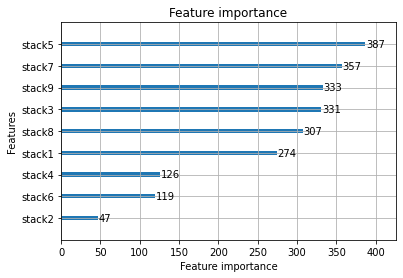

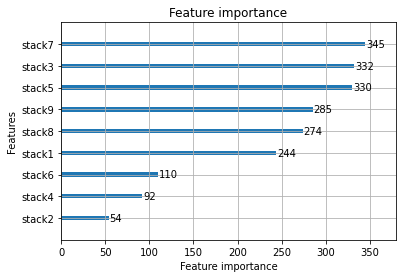

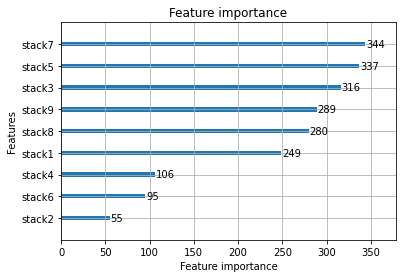

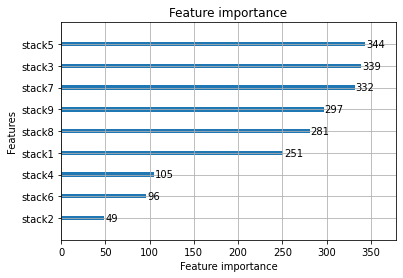

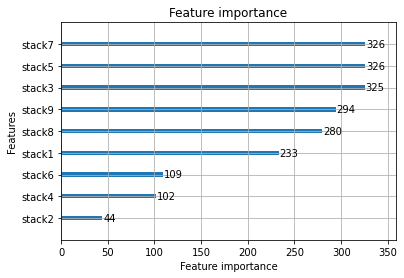

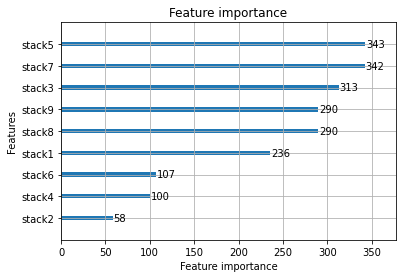

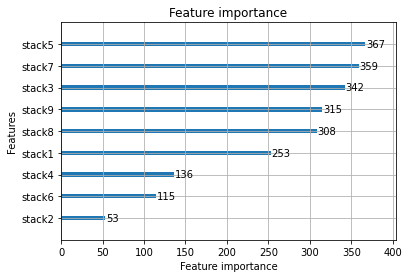

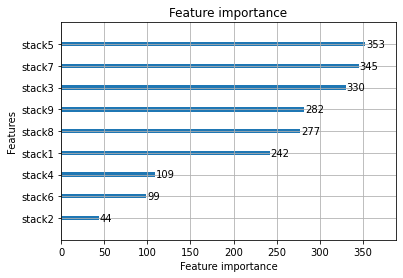

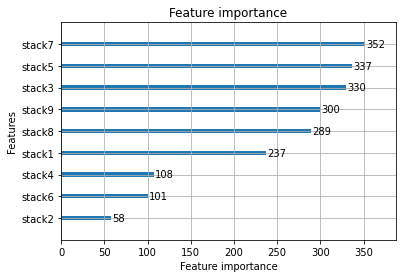

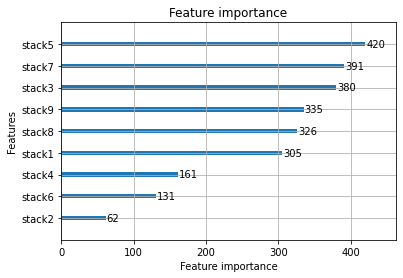

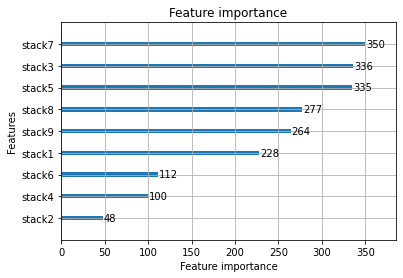

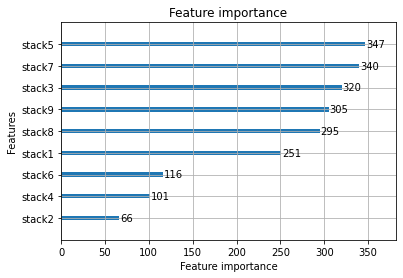

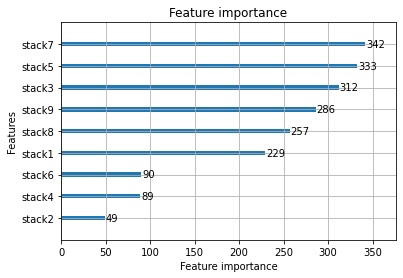

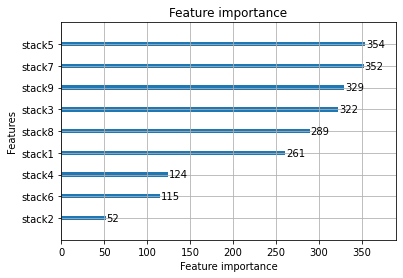

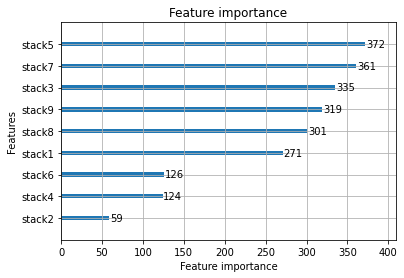

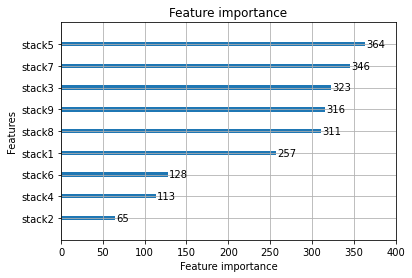

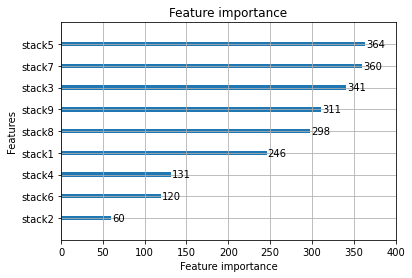

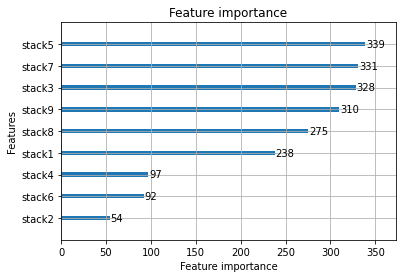

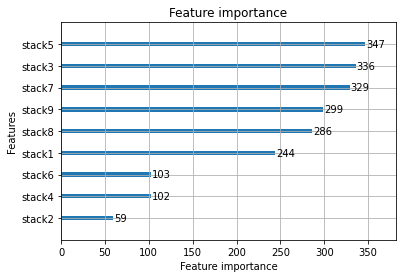

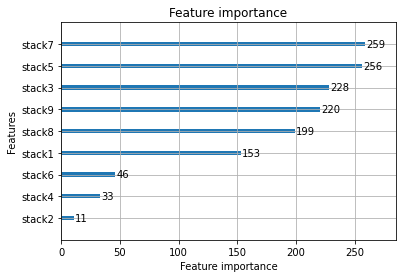

In [11]:
predictions = pd.DataFrame()
for seed in range(20):
    print("seed", seed)  # 1週30秒
    st_time = time.time()

    reg_alpha = 0
    reg_lambda = 2.972275506419662e-13
    num_leaves = 850
    colsample_bytree = 0.5621698146411757
    subsample = 0.8120024868139427
    subsample_freq = 161
    max_depth = 710
    max_bins = 685
    min_child_samples = 929
    lr = 1.1654294107978587e-06

    for fold in range(5):
        print("="*10, fold, "="*10)
        train_folds = train[train['fold']!=fold]
        valid_folds = train[train['fold']==fold]
        X_train = train_folds[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
        y_train = train_folds['target']
        X_valid = valid_folds[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]
        y_valid = valid_folds['target']
        X_test = test[['stack1', 'stack2', 'stack3', 'stack4', 'stack5', 'stack6', 'stack7', 'stack8', 'stack9']]

        model = LGBMClassifier(n_estimators = 300, learning_rate = 0.1, random_state=fold+seed*10, min_child_samples=90, num_leaves=31, max_bins=511, n_jobs=-1, max_depth=5)
        model.fit(X_train, y_train, eval_metric="auc", eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=10)], verbose=128)
        y_pred = model.predict_proba(X_valid)[:, 1]

        auc = roc_auc_score(y_valid, y_pred)
        print("auc: ", auc)
        train.loc[train['fold']==fold, 'meta'] = y_pred

        y_pred = model.predict_proba(X_test)[:, 1]
        predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis=1)
        if fold==0:
            lgb.plot_importance(model, max_num_features=30)
    en_time = time.time()
    print(en_time-st_time)

test['ensemble'] = predictions.mean(axis=1)

In [12]:
sub['target'] = test['ensemble']

In [13]:
sub[["id", 'target']].to_csv('submission.csv', index=False)

In [14]:
sub.head(10)

,id,target
0,900000,0.998082
1,900001,0.998081
2,900002,0.001830
3,900003,0.001830
4,900004,0.997872
5,900005,0.041726
6,900006,0.396596
7,900007,0.998082
8,900008,0.001891
9,900009,0.998070
